In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader

# data processing from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm

# own helping code for estimation, data processing etc.
from utils.estimating import EarlyStopper, model_estimator, kfolds_fit_and_evaluate_model, single_fit_and_evaluate_model, fit_and_evaluateHAR
from utils.preprocessing import DataSet, DataSetNump, pre_process_all_data
from utils.functions import get_rv_from_yahoo, get_rv_from_data, get_tickers_in_data, reset_model_weights, plot_tickers_in_data
from utils.modelbuilder import ForwardNeuralNetwork

# diebold mariano to compare the prediction accuracy of two different models
from dieboldmariano import dm_test

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Initial Review of the Available Data

In [2]:
print(get_tickers_in_data())
plot_tickers_in_data()

['.AEX', '.AORD', '.BFX', '.BSESN', '.BVLG', '.BVSP', '.DJI', '.FCHI', '.FTMIB', '.FTSE', '.GDAXI', '.GSPTSE', '.HSI', '.IBEX', '.IXIC', '.KS11', '.KSE', '.MXX', '.N225', '.NSEI', '.OMXC20', '.OMXHPI', '.OMXSPI', '.OSEAX', '.RUT', '.SMSI', '.SPX', '.SSEC', '.SSMI', '.STI', '.STOXX50E']


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

### Pre-Processing Data
- get data from csv file or yahoo finance api
- pre_process_all_data computes features, targets and returns them in a DataSet instance, for both HAR and NN
- plot training and testing set to get an idea of what the data looks like

Total of 5530 found for symbol: .SPX
Total training observations: 5208
Total validation observations: 300


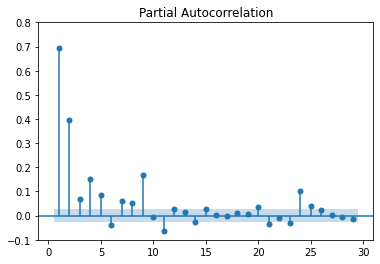

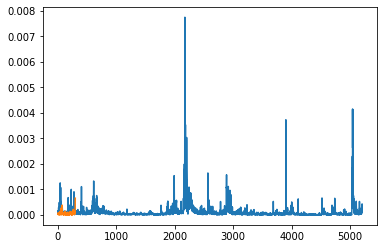

0.000111803434
4.8526617e-05


In [2]:
ticker = ".SPX" # .SSEC or .SPX

# data = get_rv_from_yahoo(ticker)
# or use ...
data = get_rv_from_data(ticker)
n_observations = len(data)
print(f"Total of {n_observations} found for symbol: {ticker}")

# data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(data, train_size=.8)
data_nn_train, data_nn_val, data_har_train, data_har_val = pre_process_all_data(data, test_size = 300)

# view some of the processed data
train_observations, test_observations = len(data_nn_train), len(data_nn_val)
print(f"Total training observations: {train_observations}")
print(f"Total validation observations: {test_observations}")

# to determine gap used in TimeSeriesSplit
plot_pacf(data_har_train.y, lags = range(1, 30))
plt.ylim(-0.1, 0.8)
plt.show()
plt.plot(data_har_train.y)
plt.plot(data_har_val.y)
plt.show()

print(np.average(data_har_train.y))
print(np.average(data_har_val.y))

### In-Sample Neural Network Estimatiom
Is it, within the parameter space of the neural network, possible to even match the HAR performance?
Perform training on several model specifications, print the lowest in sample loss together with a plot of the best output
The idea behind this is, that if the NN model cannot even perform better in-sample with a lot of training, it probably never will out-of-sample as well.

In [3]:
def fit_in_sample_return_lowest_loss_epoch(model: nn.Module, data_train, lr: int, batch_size: int, epochs: int, earlystopper: EarlyStopper, verbose=1):
    """ 
    On train data, fit model, predict model and store loss for each epoch.
    After completing all epochs, or if early stopper was triggered, return the lowest loss observed with the lowest output.
    """
     
    # NOTE: SHOULD SHUFFLE BE TRUE OR FALSE, WAS FALSE UNTIL NOW
    trainloader = DataLoader(data_train, batch_size = batch_size, shuffle = True)
            
    # initialize and train the model
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    lowest_loss = float("inf")
    lowest_output = "placeholder"
    
    for epoch in range(1, epochs+1):
        
        # train_running_loss = []
        for batch in trainloader:
            
            # each batch contains one set of features and one set of targets
            batch_features: torch.Tensor = batch[0]
            batch_targets: torch.Tensor = batch[1]
        
            # reset gradient optimizer
            optimizer.zero_grad()
            
            # with the batch features, predict the batch targets
            output = model(batch_features)
            
            # compute the loss and .backward() computes the gradient of the loss function
            loss = criterion(output, batch_targets)
            loss.backward()
            
            # update parameters (something like: params += -learning_rate * gradient)
            optimizer.step()
            
            # keep track of loss to log improvements of the fit
            # train_running_loss.append(loss.item())

        # if testdata is also provided, compute the out-of-sample performance of the model
        with torch.no_grad():
            output = model(data_nn_train.x_t).detach().numpy().reshape(-1)
            resid = data_nn_train.y_t.detach().numpy().reshape(-1) - output
            train_running_loss = np.average(resid**2)
            
            # if a lower loss is found, store this + the models output for that epoch
            if train_running_loss < lowest_loss:
                lowest_loss = train_running_loss
                lowest_output = output
                
            if verbose > 0:
                print(f"epoch {epoch} - training loss: {train_running_loss}")
            running_loss = train_running_loss

        # if an early stopper is provided, check if validation loss is still improving
        # if not, stop the estimation
        if earlystopper:
            if earlystopper.early_stop(running_loss):
                break
    return lowest_loss, lowest_output

In [5]:
# PERFORM IN-SAMPLE FIT AND VALIDATION FOR HAR
# fit HAR
HAR = OLS(endog=data_har_train.y, exog=data_har_train.x)
res = HAR.fit()
har_output = res.predict(data_har_train.x).reshape(-1,)

# compute in-sample loss
resid = data_har_train.y.reshape(-1,) - har_output.reshape(-1,)
har_loss = np.average(resid**2)
print(f"HAR in-sample loss: {har_loss}")

# PERFORM IN-SAMPLE GRID SEARCH FOR NN
model_scores = []

hidden_layers_list: tuple = ([2,],)
lr_list: tuple = (1e-3,)
epochs_list: tuple = (1000,)
patience_list: tuple = (3, 6, 9, 15)
batch_sizes: tuple = (10,)
repetitions = 5
total_model_options: int = len(hidden_layers_list) * len(lr_list) * len(epochs_list) * len(batch_sizes) * len(patience_list) * repetitions

# for all possible model and estimation configurations, perform kfold cross validation
lowest_loss = np.float("inf")
counter = 0
for hidden_layers in hidden_layers_list:
    for lr in lr_list:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patience_list:
                    for rep in range(repetitions):
                        counter += 1
                        
                        print(f"Currently at model: {counter} / {total_model_options} - lowest observed loss: {lowest_loss}", end="\r")
                        model = ForwardNeuralNetwork(
                                input_size = data_nn_train.x_t.shape[1],
                                output_size = 1,
                                hidden_layers = hidden_layers,
                                # seed=3407
                        )           
                        
                        loss, output = fit_in_sample_return_lowest_loss_epoch(
                            model,
                            data_nn_train,
                            lr,
                            batch_size,
                            epochs, 
                            earlystopper=EarlyStopper(patience=patience, min_delta=0),
                            verbose = 0
                        )
                        if loss < lowest_loss: 
                            lowest_loss = loss
                            best_output = output
                        print(f"model: hidden layers={hidden_layers} lr={lr} epochs={epochs} batch_size={batch_size} patience={patience}")
                        print(f"loss func in-sample: {loss}")
                        
                        # store the models performance in array
                        model_scores += [(loss, epochs, hidden_layers, lr, batch_size, patience)]
                    
# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr", "batch_size", 'patience'])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

# store best params as variables for the final estimation below
lowest_loss, epochs, hidden_layers, lr, batch_size, patience = df_scores.values[0]
epochs, batch_size = int(epochs), int(batch_size)

if lowest_loss > har_loss:
    print("ga maar wat beters doen met je tijd")
else:
    print("wie is HAR?")
print(f"HAR: {har_loss} NN: {lowest_loss}")

HAR in-sample loss: 3.121880354228779e-08
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=3
loss func in-sample: 3.485767763322656e-08
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=308
loss func in-sample: 4.2672564148915626e-08
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=308
loss func in-sample: 3.711850027343644e-08
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=308
loss func in-sample: 5.07463013832421e-08
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=308
loss func in-sample: 4.027697286801413e-08
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=608
loss func in-sample: 3.19083461874925e-08
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=68
loss func in-sample: 3.767808109955695e-08
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=68
loss func in-sample: 3.709679319285897e-08
model: hidden layers=[2] lr=0.001 e

In [6]:
# R^2 calculation of in sample fit
def evaluation(output_har, output_nn, data_train):

    avg = np.average(data_train)
    print('First R2 = HAR')
    print('Second R2 = ANN')
    for output in [output_har, output_nn]:
        ssr = 0
        sst = 0
        for i in range(len(data_train)):
            ssr += (data_train[i] - output[i])**2
            sst += (data_train[i] - avg)**2
            
        R2 = 1 - (ssr / sst)

        print('R2 of: {}'.format(R2))

    stat, p_value = dm_test(
    data_train, 
    output_nn,
    output_har,
    one_sided=True,
    )
    print("Diebold-Mariano test")
    print("H0: stat = 0, H1: stat < 0")
    print("I.e., p-val < p_crit implies NN performs significantly better")
    print(f"stat: {stat} p_val: {p_value}")

evaluation(output_har=har_output, output_nn=best_output, data_train=data_har_train.y.tolist())

First R2 = HAR
Second R2 = ANN
R2 of: 0.5598488822902038
R2 of: 0.557746418498395
Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 0.44712692610849786 p_val: 0.6725989919637414


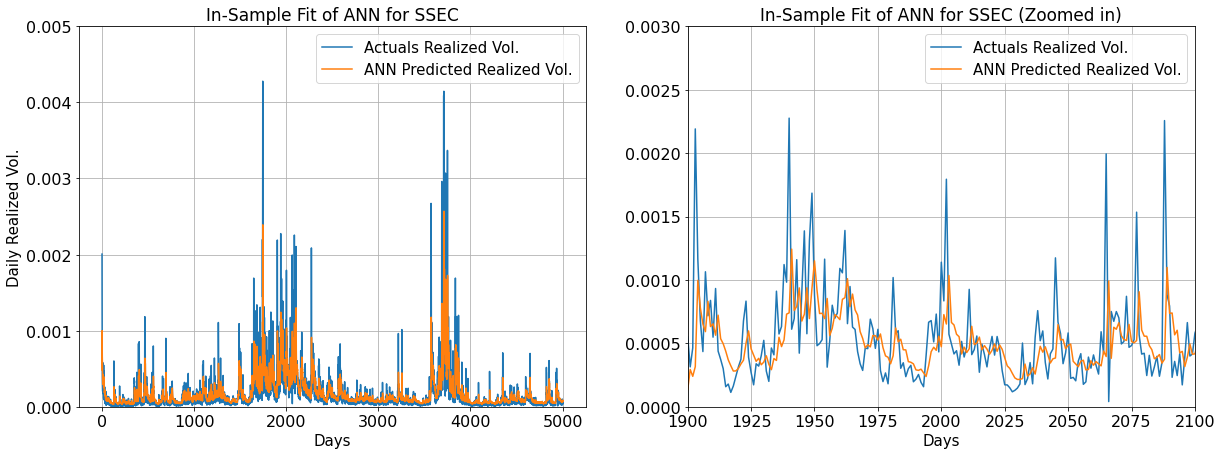

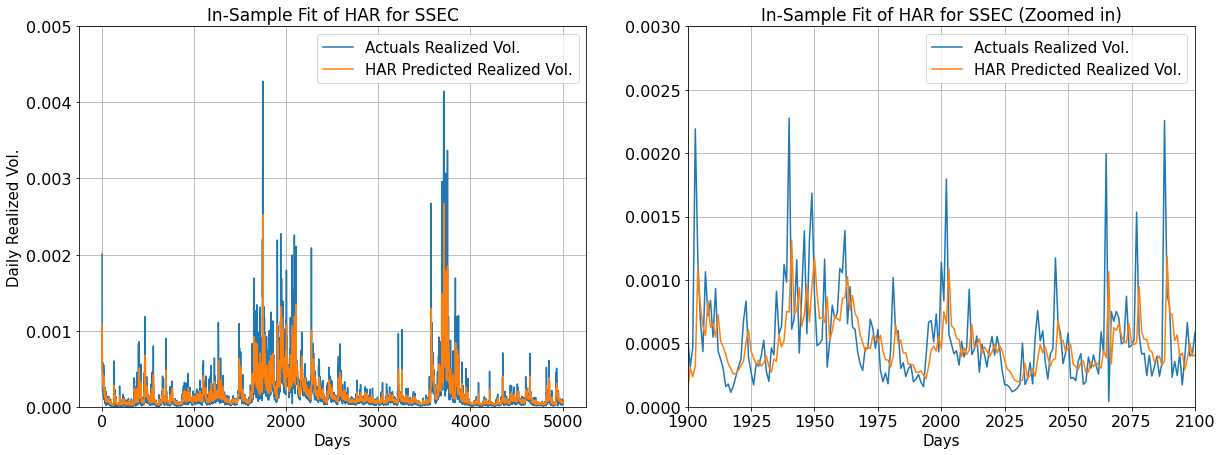

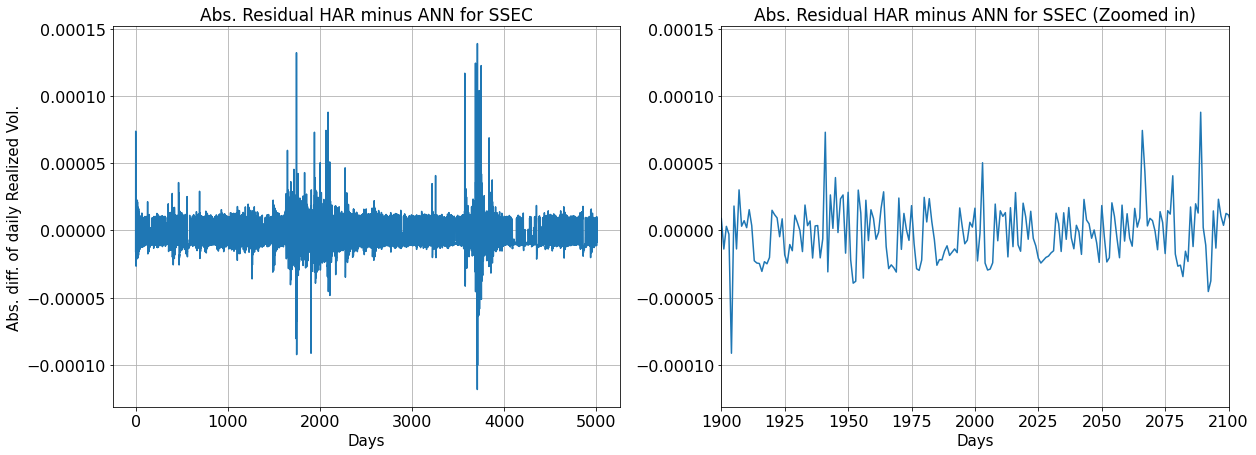

In [23]:
###################################################################################################
xstart, xend = 1900, 2100
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs[0].plot(data_nn_train.y_t.detach().numpy().reshape(-1), label="Actuals Realized Vol.")
axs[0].plot(best_output, label="ANN Predicted Realized Vol.")
axs[0].set_title(f"In-Sample Fit of ANN for {ticker[1:]}", fontsize = 17)
axs[0].set_ylabel("Daily Realized Vol.", fontsize=15)
axs[0].set_ylim(0, 0.005)

axs[1].plot(data_nn_train.y_t.detach().numpy().reshape(-1), label="Actuals Realized Vol.")
axs[1].plot(best_output, label="ANN Predicted Realized Vol.")
axs[1].set_title(f"In-Sample Fit of ANN for {ticker[1:]} (Zoomed in)", fontsize = 17)
axs[1].set_xlim(xstart,xend)
axs[1].set_ylim(0, 0.003)

for ax in axs:
    ax.set_xlabel("Days", fontsize=15)
    ax.tick_params(labelsize = 16)
    ax.legend(fontsize=15)
    ax.grid()
plt.savefig(f"images/insamplebestfit_ann_{ticker[1:]}.png", dpi=200)
plt.show()

###################################################################################################

xstart, xend = 1900, 2100
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs[0].plot(data_har_train.y.reshape(-1), label="Actuals Realized Vol.")
axs[0].plot(har_output, label="HAR Predicted Realized Vol.")
axs[0].set_title(f"In-Sample Fit of HAR for {ticker[1:]}", fontsize = 17)
axs[0].set_ylabel("Daily Realized Vol.", fontsize=15)
axs[0].set_ylim(0, 0.005)

axs[1].plot(data_har_train.y.reshape(-1), label="Actuals Realized Vol.")
axs[1].plot(har_output, label="HAR Predicted Realized Vol.")
axs[1].set_title(f"In-Sample Fit of HAR for {ticker[1:]} (Zoomed in)", fontsize = 17)
axs[1].set_xlim(xstart,xend)
axs[1].set_ylim(0, 0.003)

for ax in axs:
    ax.set_xlabel("Days", fontsize=15)
    ax.tick_params(labelsize = 16)
    ax.legend(fontsize=15)
    ax.grid()
plt.savefig(f"images/insamplebestfit_har_{ticker[1:]}.png", dpi=200)
plt.show()

###################################################################################################
nn_resid = data_har_train.y.reshape(-1) - best_output
har_resid = data_har_train.y.reshape(-1) - har_output
abs_diff = abs(har_resid) - abs(nn_resid)

xstart, xend = 1900, 2100
fig, axs = plt.subplots(1,2, figsize=(20,7))
axs[0].plot(abs_diff)
axs[0].set_title(f"Abs. Residual HAR minus ANN for {ticker[1:]}", fontsize = 17)
axs[0].set_ylabel("Abs. diff. of daily Realized Vol.", fontsize=15)
# axs[0].set_ylim(0, 0.005)

axs[1].plot(abs_diff)
axs[1].set_title(f"Abs. Residual HAR minus ANN for {ticker[1:]} (Zoomed in)", fontsize = 17)
axs[1].set_xlim(xstart,xend)
# axs[1].set_ylim(0, 0.003)

ax.set_xlabel("Days", fontsize=15)
ax.tick_params(labelsize = 16)
ax.grid()
for ax in axs:
    ax.set_xlabel("Days", fontsize=15)
    ax.tick_params(labelsize = 16)
    ax.grid()
plt.savefig(f"images/insamplebestfit_har_nn_diff_{ticker[1:]}.png", dpi=200)
plt.show()

### Model Specification of the Neural Network
Perform cross validation on a feed-forward neural network, with varying hidden layers, nodes, learning rate and epochs.
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [24]:
# PERFORM CROSS VALIDATION
model_scores = []

hidden_layers_list: tuple = ([2,],)
lr_list: tuple = (1e-3, 5e-3, 1e-3, 5e-4, 1e-4)
epochs_list: tuple = (1000,)
patience_list: tuple = (5, 10, 15)
batch_sizes: tuple = (10,)
total_model_options: int = len(hidden_layers_list) * len(lr_list) * len(epochs_list) * len(batch_sizes) * len(patience_list)
number_of_repeated_kfolds: int = int(5)

# for all possible model and estimation configurations, perform kfold cross validation
counter = 0
for hidden_layers in hidden_layers_list:
    for lr in lr_list:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patience_list:
            
                    counter += 1
                    print(f"Currently at model: {counter} / {total_model_options}", end="\r")
                    
                    avg_score_multiple_folds_list = [           
                        # fit and evaluate model through cross validation
                        kfolds_fit_and_evaluate_model(
                            input_size = data_nn_train.x_t.shape[1],
                            output_size = 1,
                            hidden_layers = hidden_layers,
                            # kfold = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 500, gap = 25), # the test_size = len(data) // (n_splits + 1)
                            kfold = TimeSeriesSplit(n_splits = 8, max_train_size = None, test_size = 300, gap = 25), # the test_size = len(data) // (n_splits + 1)
                            data = data_nn_train,
                            lr = lr, 
                            epochs = epochs, 
                            earlystopper = EarlyStopper(patience=patience, min_delta=0),
                            normalize_features = False,
                            batch_size = batch_size,
                        )
                        for i in range(number_of_repeated_kfolds)
                    ]
                    
                    avg_score_multiple_folds = np.average(avg_score_multiple_folds_list)
                    
                    print(f"model: hidden layers={hidden_layers} lr={lr} epochs={epochs} batch_size={batch_size} patience={patience}")
                    print(f"avg score: {avg_score_multiple_folds} list of scores: {avg_score_multiple_folds_list}")
                    
                    # store the models performance in array
                    model_scores += [(avg_score_multiple_folds, epochs, hidden_layers, lr, batch_size, patience)]
                    # model_scores += [(score_nn, epochs, hidden_layers, lr)]

# put all scores with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr", "batch_size", 'patience'])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
print(df_scores.head(10))

model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=5
avg score: 7.241916222255895e-08 list of scores: [7.8416996e-08, 6.795182e-08, 8.1990194e-08, 5.9455306e-08, 7.4281516e-08]
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=10
avg score: 8.157024922184064e-08 list of scores: [9.542321e-08, 7.9298395e-08, 8.681147e-08, 7.889716e-08, 6.7421e-08]
model: hidden layers=[2] lr=0.001 epochs=1000 batch_size=10 patience=15
avg score: 1.207903608246852e-07 list of scores: [3.0596806e-07, 9.172357e-08, 6.6542675e-08, 6.63392e-08, 7.337834e-08]
model: hidden layers=[2] lr=0.005 epochs=1000 batch_size=10 patience=5
avg score: 8.722615518763632e-08 list of scores: [8.450323e-08, 6.320805e-08, 9.187639e-08, 7.353987e-08, 1.2300322e-07]
model: hidden layers=[2] lr=0.005 epochs=1000 batch_size=10 patience=10
avg score: 1.2439285512755305e-07 list of scores: [8.344895e-08, 5.421814e-08, 2.8059475e-07, 9.458227e-08, 1.09120165e-07]
model: hidden layers=[2] lr=0.005

### Fit and Compare the Final Neural Network Against the HAR Model

No params from cross validation, using own params instead
Or specifically specified to use own params
HAR out-of-sample loss: 2.7338040720081835e-09


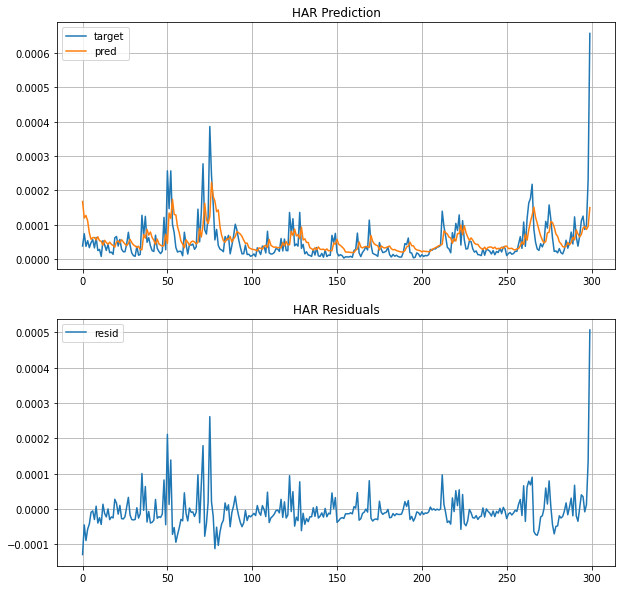

Estimating NN model ...
... with epochs=1000, hidden_layers=[2], lr=0.001, patience=20
NN out-of-sample loss: 2.425337086719992e-08 - best loss: inf


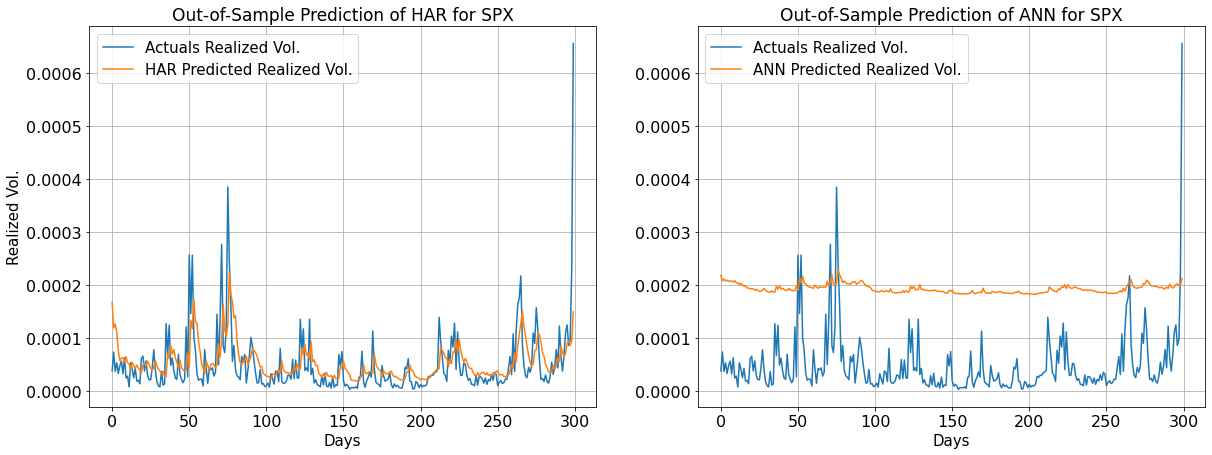

Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 30.224360906061168 p_val: 1.0
NN out-of-sample loss: 3.482834909362964e-09 - best loss: 2.425337086719992e-08


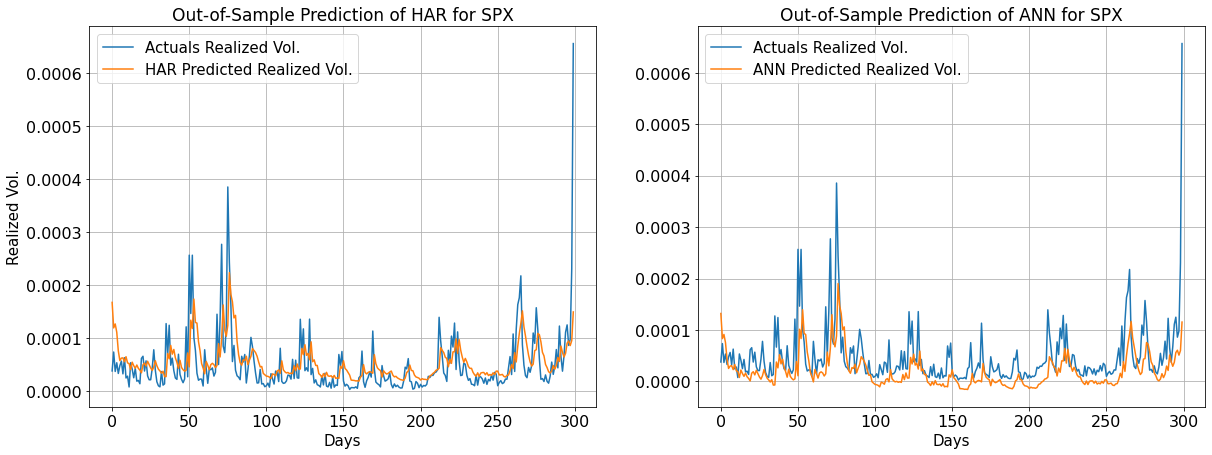

Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 3.6222465238897428 p_val: 0.9998284933599957
NN out-of-sample loss: 8.495021575072315e-08 - best loss: 3.482834909362964e-09
NN out-of-sample loss: 2.9023079051171408e-08 - best loss: 3.482834909362964e-09
NN out-of-sample loss: 5.6045710294938544e-09 - best loss: 3.482834909362964e-09
NN out-of-sample loss: 5.824682958177618e-09 - best loss: 3.482834909362964e-09
NN out-of-sample loss: 6.895151472008365e-08 - best loss: 3.482834909362964e-09
NN out-of-sample loss: 2.8783275762833682e-09 - best loss: 3.482834909362964e-09


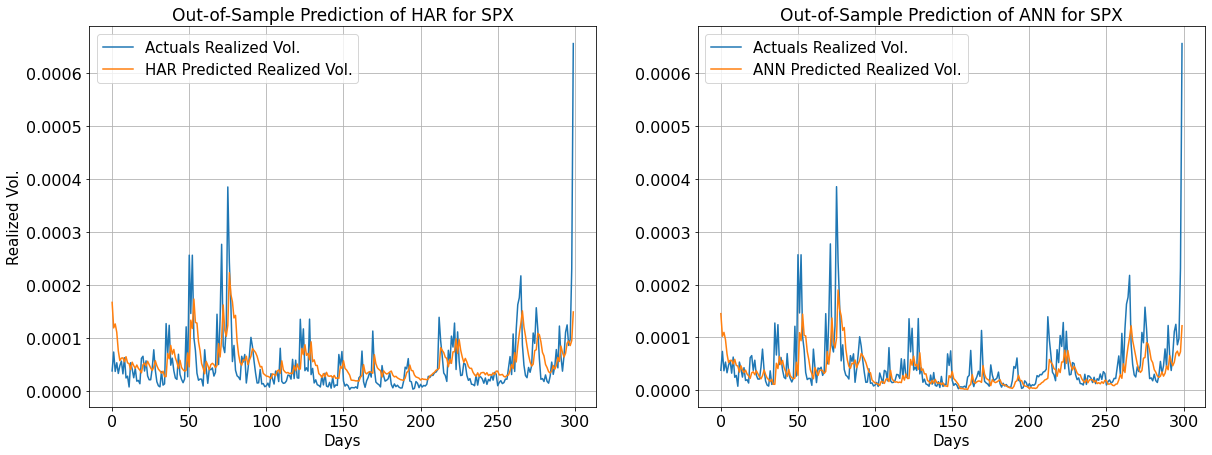

Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: 1.0394293475625056 p_val: 0.8502775529132798
NN out-of-sample loss: 9.065074380032456e-08 - best loss: 2.8783275762833682e-09
NN out-of-sample loss: 3.41396706460273e-08 - best loss: 2.8783275762833682e-09


KeyboardInterrupt: 

In [7]:
normalize_features = False
use_own_config = True # !!! if you use this once after the cross validation, the custom hyperparams below 'overwrite' those from cross validation above

# sometimes we want to zoom in on specific intervals of the forecast
idx_start, idx_end = 0, 10000

# if the params are not set through cross validations above
try:
    epochs, lr, hidden_layers
    if use_own_config: raise Exception()
except Exception as e:
    print("No params from cross validation, using own params instead")
    print("Or specifically specified to use own params")
    epochs = int(1e3)
    hidden_layers = [2,] # zero or one with 2 nodes
    lr = 1e-3 # .SPX=1e-3, .SSEC=5e-4
    batch_size = 10
    patience = 20

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
# the goal was to instantiate the model before passing it to the estimation function, so we can use the model here
# this does not work
HAR = OLS(np.zeros(10), np.zeros(10)) # these params are placeholders
loss, output = fit_and_evaluateHAR(
    model = HAR,
    data_train = data_har_train,
    data_test = data_har_val,
    normalize_features = False
)
har_loss = loss
har_output = output.copy().reshape(-1,)

print(f"HAR out-of-sample loss: {loss}")

plot = True
if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (10, 10))
    axs[0].set_title("HAR Prediction")
    axs[1].set_title("HAR Residuals")
    axs[0].plot(data_har_val.y[idx_start:idx_end], label = "target")
    axs[0].plot(output[idx_start:idx_end], label = "pred")
    axs[1].plot((data_har_val.y - output)[idx_start:idx_end], label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================
print("Estimating NN model ...")
print(f"... with epochs={epochs}, hidden_layers={hidden_layers}, lr={lr}, patience={patience}")

best_loss = float("inf")
best_output: np.ndarray
while True:
    NN = ForwardNeuralNetwork(
        data_nn_train.x_t.shape[1], 
        output_size = 1, 
        hidden_layers=hidden_layers, 
        # seed=3407
        )
    nn_loss, output = single_fit_and_evaluate_model(
        NN,
        data_train = data_nn_train,
        data_test = data_nn_val,
        lr = lr,
        epochs = epochs,
        earlystopper = EarlyStopper(patience=patience, min_delta=0),
        normalize_features = False,
        return_prediction = True,
        batch_size=batch_size
    )

    nn_output =  output.detach().numpy().reshape(-1,)
    true_output = data_har_val.y.reshape(-1,)
    print(f"NN out-of-sample loss: {nn_loss} - best loss: {best_loss}")
    
    if nn_loss < best_loss: 
        best_loss = nn_loss
        best_output = nn_output

        plot = True
        if plot:
            # plot prediction versus true daily volatility
            target = data_nn_val.y_t.detach().numpy().reshape(-1,)
            har_resid = target - har_output.reshape(-1,)
            nn_resid = target - nn_output
            
            fig, axs = plt.subplots(1,2, figsize = (20, 7))
            axs[0].set_title(f"Out-of-Sample Prediction of HAR for {ticker[1:]}", fontsize = 17)
            axs[0].plot(target, label = "Actuals Realized Vol.")
            axs[0].plot(har_output.reshape(-1,), label="HAR Predicted Realized Vol.")
            axs[0].set_ylabel("Realized Vol.", fontsize=15)
            axs[1].set_title(f"Out-of-Sample Prediction of ANN for {ticker[1:]}", fontsize = 17)
            axs[1].plot(target, label = "Actuals Realized Vol.")
            axs[1].plot(nn_output.reshape(-1,), label="ANN Predicted Realized Vol.")

            for ax in axs:
                ax.set_xlabel("Days", fontsize=15)
                ax.tick_params(labelsize = 16)
                ax.legend(fontsize=15)
                # ax.set_ylim(0, 0.00045)
                ax.grid()
                
            plt.show()
    
        #=========================================================================================
        #====================================DIEBOLD-MARIANO======================================
        #=========================================================================================
        stat, p_value = dm_test(
            data_har_val.y, 
            nn_output,
            har_output, 
            one_sided=True,
        )
        print("Diebold-Mariano test")
        print("H0: stat = 0, H1: stat < 0")
        print("I.e., p-val < p_crit implies NN performs significantly better")
        print(f"stat: {stat} p_val: {p_value}")
        # if one sided, only test if the upper forecast performs significantly better than the lower forecast

In [21]:
evaluation(output_har=har_output, output_nn=best_output, data_train=data_har_val.y.tolist())

First R2 = HAR
Second R2 = ANN
R2 of: 0.2126083463928139
R2 of: 0.21735018259819538
Diebold-Mariano test
H0: stat = 0, H1: stat < 0
I.e., p-val < p_crit implies NN performs significantly better
stat: -0.21369723428753232 p_val: 0.4154644067227018


In [ ]:
# code snippet to print the parameters of the trained model
for name, param in NN.named_parameters():
    if param.requires_grad:
        print(name, param.data[0])

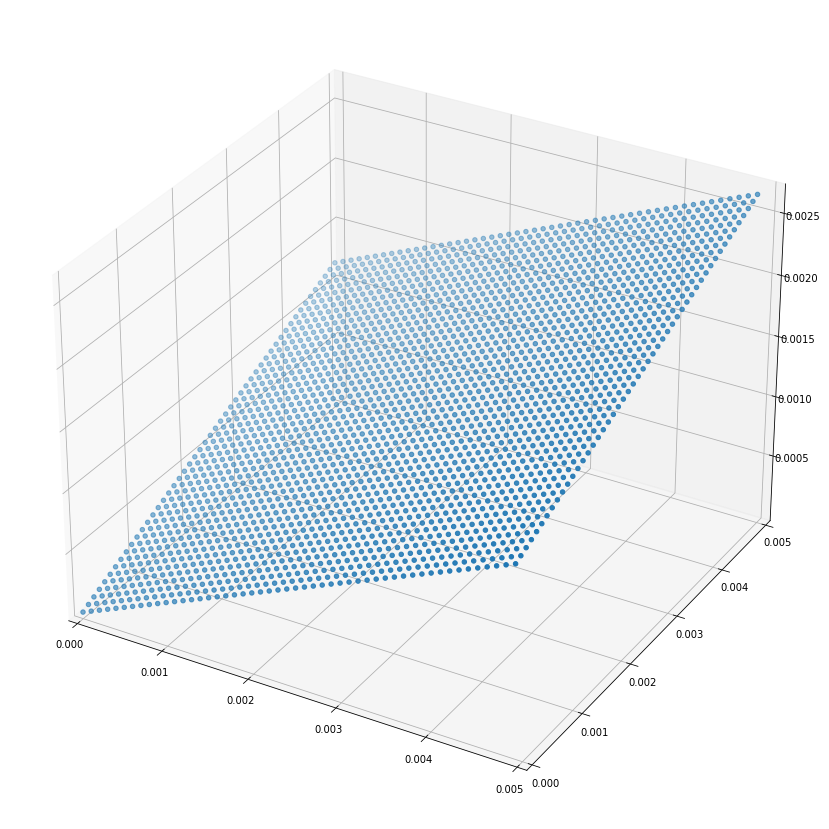

In [125]:
X = np.arange(0, 0.005, .0001)
Y = np.arange(0, 0.005, .0001)
Zconstant = 0
NN = model
features = np.zeros((len(X)*len(Y), 3))
i = 0
for Xi in X:
    for Yi in Y:
        features[i] = (Zconstant, Xi, Yi)
        i += 1
X = torch.tensor(features, dtype=torch.float32)

Y = NN(X).detach().numpy().reshape(-1,)
X = X.detach().numpy()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

X, Y, Z = X[:,1], X[:, 2], Y
ax.scatter(X, Y, Z)
ax.set_xlim(0, 0.005)
ax.set_ylim(0, 0.005)
ax.set_zlim(min(Z), max(Z))
plt.show()


In [4]:
# code snippet to get an idea of how TimeSeriesSplit divides the data
kfold = TimeSeriesSplit(n_splits = 8, max_train_size = None, test_size=300, gap=25)
for idx_train, idx_test in kfold.split(data_nn_train.x_t):
    train_start, train_end = idx_train[0], idx_train[-1]
    test_start, test_end = idx_test[0], idx_test[-1]
    print(train_start, train_end, "-", test_start, test_end)


0 2782 - 2808 3107
0 3082 - 3108 3407
0 3382 - 3408 3707
0 3682 - 3708 4007
0 3982 - 4008 4307
0 4282 - 4308 4607
0 4582 - 4608 4907
0 4882 - 4908 5207
